# <center> ANT CORPSE CLUSTERING


<div style="text-align: jusitfy">

<p> Dans le cadre de notre ARE, nous avons decidé de travailler sur l'étude comportementale des fourmis. En effet, nous allons étudier un phénomène naturel observable dans la nature: les fourmis agrègent leur morts en vastes tas de maniére regulière dans l'espace. Au fur et à mesure du temps, elles finissent par ne former qu'un seul et unique tas. Ce phénomène est observable à l'intérieur ou à l'extérieur des fourmilières (dans le cas des fourmilières, une pièce de la fourmilière est spécialement dédiée au rassemblement des cadavres de fourmis).<p> <br/>
<div>


![Image](https://www.researchgate.net/profile/Guy_Theraulaz/publication/6780365/figure/fig3/AS:394664680149009@1471106800860/Spatio-temporal-dynamics-Typical-spatio-temporal-dynamics-of-corpse-clustering-by-ants.png)<br/>
<div style="text-align: center, italic"> Exemple de formation de tas de cadavres par des fourmis (vue de dessus).<div>


<div style="text-align: jusitfy">
<p><br/>Tout au long de ce compte-rendu, notre but sera donc d'implémenter différents modèles afin d'aboutir, dans un premier tas, à la formation de tas individuels séparés, puis à la formation d'un seul et unique tas similaire à celui que l'on peut observer dans la réalité (on le considèrera comme l'état final de notre système). Nous discuterons donc la pertinence de chaque modèle en dégageant clairement leurs avantages et leurs inconvénients et en proposant des solutions afin de les améliorer lorsque cela est réalisable.<p>
    
<div>

# Première approche : un modèle simplifié

Pour notre première approche nous avons décidé d'implementer un modèle simple. Nous modélisons le sol sur lequel les fourmis se déplacent par une grille d'une longueur et d'une largeur fixées. Chaque case de la grille est soit vide (__blanche__), soit elle contient un cadavre (__noire__), soit elle contient une fourmi vivante (__verte__), soit elle contient une fourmi vivante portant un cadavre (__rouge__).

On représente cette grille sous la forme d'un tableau numpy dans laquelle est stocké un entier entre 0 et 3 en fonction de l'état de la case. 



 

In [1]:
import copy
from tkinter import Tk, Canvas, Button, RIGHT, LEFT
import numpy as np
from random import randint,randrange,choice,sample
import matplotlib.pyplot as plt


In [2]:
#Paramètres de la grille:
lignes=50
colonnes=50
cellule=15 #Taille d'une case

#dictionnaire d'états des cellules
state={"EMPTY":0, "DEAD":1, "ALIVE":2, "CARRIER":3}

#On définit deux tableaux numpy représentant notre grille :
etat = np.zeros((lignes,colonnes),dtype=int)  #Matrice d'entiers contenant l'état de chaque cellule
cell = np.zeros((lignes,colonnes),dtype=int)  #Matrice d'entiers servant à l'affichage graphique

#Etat initial (nombre de mort et de vivant sur la grille de base):
init={"DEAD":200, "ALIVE": 20}


### Règles du modèle: 


  - Une fourmi se deplace dans huit directions de manière aleatoire<br/>
  - Chaque fourmi à trois états possibles, elle peut être soit morte, soit vivante, soit vivante et porteuse d'une fourmi morte<br/>
  - Une fourmi vivante ne peut marcher ni sur un cadavre ni sur une autre fourmi vivante (porteuse ou non), elle évite tous les obstacles<br/>
  - Dès qu'une fourmi libre est dans le voisinage d'un ou plusieurs corps elle en ramasse un au hasard et continue de bouger aléatoirement.
  - Dès qu'une fourmi chargée est dans le voisinage d'un ou plusieurs corps, elle dépose le corps qu'elle porte dans le voisinage d'un corps choisi au hasard.
  - La fourmi ne prend en compte que la présence d'autres fourmis dans son voisinage afin de prendre une décision donc aucune probabilité n'est definie.<br/>

In [3]:
def set_corpse(i,j,tab):
    """int*int->set[tuple[int,int]]
    Renvoie l'ensemble des coordonnées des corps proches d'une fourmi de coordonnées i,j sous forme de liste
    S'il n'y en a aucun : retourne un set vide
    """
    #Note : on considere deux cellules proches si un de leur côté ou sommet se touchent (modèle à 8 directions)
    
    #res:  set(tuple(int,int))
    res = set()
 
    L=[(i+1,j),(i-1,j),(i,j+1),(i,j-1),(i+1,j-1),(i+1,j+1),(i-1,j+1),(i-1,j-1)] #Sud,Nord,Est,Ouest,Sud-Ouest,Sud-Est,Nord-est,Nord-ouest
    
    for (x,y) in L:
        if (x>=0 and x<lignes and y>=0 and y<colonnes):
            if tab[x][y]==state["DEAD"]:
                res.add((x,y))
    return res


def move_ants(i,j,tab):
    """Fais bouger la fourmi de coordonnees i,j sur une case vide s'il n'y a pas de corps à côté"""
    
    L=[(i+1,j),(i-1,j),(i,j+1),(i,j-1),(i+1,j-1),(i+1,j+1),(i-1,j+1),(i-1,j-1)] #Sud,Nord,Est,Ouest,Sud-Ouest,Sud-Est,Nord-est,Nord-ouest
    
    x,y=choice(L)
    
    while ((0>x or x>=lignes) or (y<0 or y>=colonnes) or tab[x][y]!=state["EMPTY"]): #Tant que l'on ne tombe pas dans une case non occupée qui est dans la fenetre 
        x,y=choice(L)
        
      
    tab[x][y]=etat[i][j]
    tab[i][j]=state["EMPTY"]

def drop_corpse(i,j,tab):
    """Fais en sorte qu'une fourmi chargée de coordonées i,j dépose un corps à proximité du corps de coordonées x,y"""
    
    deads=set_corpse(i,j,tab)
    x,y=sample(deads,1)[0] #on récupère les coordonées d'un mort au hasard
    
    L=[(x+1,y),(x-1,y),(x,y+1),(x,y-1),(x+1,y-1),(x+1,y+1),(x-1,y+1),(x-1,y-1)] #On construit le voisinage du mort choisi
    
    l,c=choice(L) #on choisit au hasard une case voisine du corps choisi
    
    while ((0>l or l>=lignes) or (c<0 or c>=colonnes) or tab[l][c]!=state["EMPTY"]  or (l==i and c==j)): #Tant que l'on ne tombe pas dans une case non occupée qui est dans la fenetre
            l,c=choice(L)
            
    
    tab[l][c]=state["DEAD"]
    tab[i][j]=state["ALIVE"]

In [4]:
def initialise_interface(): 
    """None -> None
    Répartis les nombres initiaux de corps et de fourmis vivantes à des positions aléatoires sur la grille"""
    
    #On commence par mettre des cases vides partout
    
    for i in range(lignes):
        for j in range(colonnes):
            cell[i][j]=canvas.create_rectangle((i*cellule, j*cellule, (i+1)*cellule, (j+1)*cellule), outline="gray", fill="white")
    
    morts=init["DEAD"]
    vivants=init["ALIVE"] #Nombres initiaux de corps, fourmis à placer
    
    temp=[e for e in init.keys()]  
    
    #Puis on mets les morts et les vivants
    
    while (vivants!=0 or morts!=0):
        i=randrange(0,lignes)
        j=randrange(0,colonnes)   #tire des coordonnées aléatoires
        while etat[i][j]!=0:  #Tant qu'elle corresponde à des cases déjà occupée on recommence
            i=randrange(0,lignes)
            j=randrange(0,colonnes)
        x=randint(0,1)   #Tire un nombre entre 0 et 1 (deux éléments dans temp)
        if temp[x]=="DEAD":
            if morts!=0:
                etat[i][j]=state["DEAD"] #état de la cellule initialisé comme morte
                cell[i][j]=canvas.create_rectangle((i*cellule, j*cellule, (i+1)*cellule, (j+1)*cellule), outline="gray", fill="black") #Création du rectangle de couleur noire représentant un cadavre
                morts-=1
        else:
            if vivants!=0:
                etat[i][j]=state["ALIVE"]
                cell[i][j]=canvas.create_rectangle((i*cellule, j*cellule, (i+1)*cellule, (j+1)*cellule), outline="gray", fill="green")
                vivants-=1
        

    

def next_generation():
    """Fais passer le modèle à la génération suivante en suivant les règles du modèle d'Unige"""
    global etat
    temp=np.zeros((lignes,colonnes),dtype=int) #initialisation d'un nouveau tableau
    
    for i in range(lignes):
        for j in range(colonnes):
            if (etat[i][j]==state["DEAD"]): #Remplissage des morts
                temp[i][j]=state["DEAD"]
                
    for i in range(lignes):
        for j in range(colonnes):
            
            if (etat[i][j]==state["ALIVE"]):  #Si on tombe sur une fourmi vivante
                deads=set_corpse(i,j,temp) #ensembles des morts entourants la fourmi
                if len(deads)==0:
                    move_ants(i,j,temp)
                else:
                    x,y=sample(deads,1)[0] #récupère les coordonnées d'un mort aléatoire

                    temp[x][y]=state["EMPTY"]   #La fourmi ramasse le mort
                    temp[i][j]=state["CARRIER"]
                    
            if (etat[i][j]==state["CARRIER"]):  #Si on tombe sur une fourmi porteuse
                deads=set_corpse(i,j,temp)
                if len(deads)==0:
                    move_ants(i,j,temp) #S'il n'y a pas de morts aux alentours on bouge
                else:
                    drop_corpse(i,j,temp) #Sinon on dépose le corps
                
                
    etat=temp.copy()

In [5]:
# Dessiner toutes les cellules
def dessiner():
    for x in range(lignes):
        for y in range(colonnes):
            if etat[x][y]==state["EMPTY"]:
                coul = "white"
            if etat[x][y]==state["ALIVE"]:
                coul = "green"
            if etat[x][y]==state["DEAD"]:
                coul = "black"
            if etat[x][y]==state["CARRIER"]:
                coul = "red"
            canvas.itemconfig(cell[x][y], fill=coul)

# Arrêt de l'animation
def stop():
    global flag
    flag=0

# Calculer et dessiner la prochaine génération
def iterer():
    global flag
    dessiner()
    next_generation()
    if flag==1:
        fenetre.after(100, iterer)
    else:
        flag=0

# Démarrage de l'animation
def start():
    global flag
    if flag==0: 
        flag=1
    iterer()

# Animation pas à  pas
def pasapas():
    global flag
    flag=2
    iterer()

#Création de la fenêtre:
fenetre=Tk()
fenetre.title("Modele d'Unige")
canvas=Canvas(fenetre,width=colonnes*cellule+1, height=lignes*cellule+1,highlightthickness=0)
fenetre.wm_attributes("-topmost",True) #Sert à afficher la fenetre on top

#Affichage de la grille
canvas.pack()

#Définition des boutons :

bou1 = Button(fenetre,text='Exit', width=8, command=fenetre.destroy)
bou1.pack(side=RIGHT)
bou2 = Button(fenetre, text='Start', width=8, command=start)
bou2.pack(side=LEFT)
bou3 = Button(fenetre, text='Stop', width=8, command=stop)
bou3.pack(side=LEFT)
bou4 = Button(fenetre, text='Step', width=8, command=pasapas)
bou4.pack(side=LEFT)


In [6]:
#Démarrage de la simulation

flag=0
initialise_interface()          
iterer()
fenetre.mainloop()
    

# Modèle de Deneubourg simplifié

<div style="text-align: jusitfy">

<p>
Nous allons à présent implémenter un second modèle afin de pouvoir comparer l'efficacité des différents modèles. Ce modèle s'inspire d'un modèle déjà existant : le modèle de Deneubourg. Toutefois, nous avons décidé de simplifier son fonctionnement pour pouvoir l'implémenter avec Python.</p>

</div>
<p>
Dans le modèle de Deneubourg original, chaque fourmi dispose d'une mémoire M. Cette mémoire permet d'influencer la porbabilité qu'à une fourmi vivante de déposer ou prendre un corps.Nous avons décider de supprimer cette mémoire. Les probabilité ne seront influencées que par le voisinage de la fourmi. On définit alors deux constantes $k_{1}$ et $k_{2}$.
</p>

<p>
La probabilité $P_{p}$ qu'à une fourmi vivante de prendre un corps qu'elle croise est alors 0 si le nombre de fourmi morte voisine du corps est plus grand que k1 sinon elle vaut 1.
</p>

<p>
La probabilité $P_{d}$ qu'à une fourmi porteuse de déposer un corps qu'elle porte est alors 1 si le nombre de fourmi morte voisine du corps est plus grand que k1 sinon elle vaut 0.
</p>


In [27]:
#On importe les bibliothèques nécessaires

from tkinter import Tk, Canvas, Button, LEFT, RIGHT 
import numpy as np
from random import randint,randrange,choice,sample
import matplotlib.pyplot as plt
import time

Le modèle de Deneubourg simplifié respecte les règles suivantes :
  
  
  - Chaque fourmi se déplace selon 4 directions de façon aléatoire.<br/>
  - Chaque fourmi à trois etats elle peut être soit morte, soit vivante, soit vivante et porteuse d'une fourmi morte.<br/>
  - Une fourmi vivante peut marcher sur un cadavre de fourmi mais pas sur une fourmi vivante (porteuse ou non).<br/>
  - Une fourmi vivante (non porteuse) à une probabilité $P_{p}$ de ramasser un cadavre qu'elle rencontre.<br/>
  - Une fourmi porteuse à une probabilité $P_{d}$ de déposer le corps qu'elle porte.<br/>



In [28]:
 #On définit les constantes suivantes

lignes=25 #Nombre de lignes sur la grille
colonnes=25#Nombre de colonnes sur la grille
cellule=15#Taille d'une cellule

k1=4 #Paramètres du modèle de Deneubourg
k2=4

morts=np.zeros((lignes,colonnes),dtype=int)  #Matrice d'entiers contenant les fourmis mortes de chaque cellule et les cellules vides
vivants=np.zeros((lignes,colonnes),dtype=int) #Tableau contenant les vivants
cell = np.zeros((lignes,colonnes),dtype=int)  #Matrice d'entiers servant à l'affichage graphique

#On définit un dictionnaire des différents états que peut prendre une case de la grille :
state={"EMPTY":0,"DEAD":1,"ALIVE":2,"CARRIER":3}

#Puis un dictionnaire du nombre de morts et de vivants que l'on veut placer aléatoirement sur le plateau:
init={"DEAD":400, "ALIVE":100}

#Liste des fourmis dans lesquels seront stockées nos objets fourmi
FOURMIS=[]



In [29]:
#on definit un objet qui coresônd a une fourmi vivante 
class Ant:
    
    def __init__(self,i,j):  #définition des caractèristiques propres à une fourmi
        self._memory=[]
        self._ligne=i #coordonnées de la fourmi 
        self._colonne=j
        self._etat=state["ALIVE"] #état : mort, vivant, porteuse
        self._MUST_MOVE=True #Pour savoir si la fourmi doit être déplacée ou non (évite les multiples déplacements)
        
    def move_ant(self,tab):
        """Méthode à utiliser pour faire bouger la fourmi de coordonnees sur une case vide s'il n'y a pas de corps à côté"""
        
        L=[(self._ligne,self._colonne+1),(self._ligne,self._colonne-1),(self._ligne+1,self._colonne),(self._ligne-1,self._colonne)] #déplacement à 4 directions
        
        possible=False  #Déplacement possible ou non 
        
        for (l,c) in L:  #On parcourt la liste des déplacments
            if ((c>=0 and c<lignes) and (l>=0 and l<colonnes)): #Si l'indice ne dépasse pas le tableau
                if tab[l,c]==state["EMPTY"]: #Si un déplacement est possible on met le booléen à true
                    possible=True
                    break #Et on sort de la boucle
        
        if possible: #Si un au moins un déplacement est possible, on bouge une fourmi aléatoirement
            
            i=randint(0,len(L)-1)
            x,y=L[i]
        
            while ((0>x or x>=lignes) or (y<0 or y>=colonnes) or tab[x][y]==state["ALIVE"] or tab[x][y]==state["CARRIER"]):#Une fourmi qui se déplace peut marcher sur des corps ou des cases vides mais pas sur d'autres fourmis vivantes
                i=randint(0,len(L)-1)
                x,y=L[i]
        
            tab[x][y]=self._etat
            tab[self._ligne][self._colonne]=state["EMPTY"]
            self._ligne=x
            self._colonne=y
                
        else: #Sinon on remet la fourmi a une case aléatoire sur la grille
            x=randrange(0,lignes)
            y=randrange(0,colonnes)   #tire des coordonnées aléatoires
        
            while (vivants[x][y]!=state["EMPTY"]) :
                x=randrange(0,lignes)
                y=randrange(0,colonnes)
                
            tab[x][y]=self._etat
            tab[self._ligne][self._colonne]=state["EMPTY"]
            self._ligne=x
            self._colonne=y
            
    def probability_peak_up(self,tab_morts):   #k1 est un paramètre fixe faisant partie du modèle 
        """méthode qui retourne la probabilité qu'à une fourmi de prendre un corps selon le nombre de fourmi qu'elle a croisé auparavant"""
        
        if number_of_corpse(self._ligne,self._colonne,tab_morts)>=k1:
            return 0
        else:
            return 1
    
    def probability_drop_corpse(self,tab_morts): #k2 est un paramètre 
        """méthode qui retourne la probabilité qu'à une fourmi de déposer un corps selon le nombre de fourmi qu'elle a croisé auparavant"""
        
        if number_of_corpse(self._ligne,self._colonne,tab_morts)>k2:
            return 1
        else:
            return 0
   
    def pick_up_corpse(self,tab_vivants,tab_morts):
        """méthode à utiliser pour ramasser un corps ou bouger si elle ne marche pas sur un corps"""
        
        probability_percent=self.probability_peak_up(tab_morts)*100 #Nombres de chance sur cent de prendre un corps
        aleatoire=randint(0,100) #On tire un nombre aléatoire entre 0 et 1
        
        if  aleatoire<=probability_percent: 
            
            if tab_morts[self._ligne][self._colonne]==state["DEAD"]: #Si la case sur laquelle se tient la fourmi contient un mort, elle le ramasse
                self._etat=state["CARRIER"]#elle devient donc porteuse
                tab_morts[self._ligne][self._colonne]=state["EMPTY"] #la case où était la fourmi morte devient vide
                
        #self.move_ant(tab_vivants) #On bouge dans tous les cas à la fin (que la case ait été libre ou non)
                
    def drop_corpse(self, tab_vivants, tab_morts):
        """méthode à utiliser pour faire en sorte qu'une fourmi chargée dépose le corps qu'elle transporte ou bouge si la case sur laquelle elle se trouve est vide, 
        elle bouge sinon"""
         
        probability_percent=self.probability_drop_corpse(tab_morts)*100 #Nombres de chance sur cent de prendre un corps
        aleatoire=randint(0,100) #On tire un nombre aléatoire entre 0 et 1
         
        if aleatoire<=probability_percent:
             
            if tab_morts[self._ligne][self._colonne]==state["EMPTY"]: #Si la case sur laquelle se tient la fourmi est vide
                self._etat=state["ALIVE"] #elle redevient une fourmi non chargée
                tab_morts[self._ligne][self._colonne]=state["DEAD"] #On ajoute le mort
                 
         #self.move_ant(tab_vivants)
            
            
        

In [30]:
#On crée une fonction qui va initialiser le plateau et créer toutes les fourmis
def initialise():
    """fonction qui initialise la grille en placant des morts et des vivants de façon aléatoire et qui créer les fourmis et les stocke dans une liste"""
    
    global FOURMIS
    
    #On commence par mettre des cases vides partout
    for i in range(lignes):
        for j in range(colonnes):
            cell[i,j]=canvas.create_rectangle(j*cellule, i*cellule, (j+1)*cellule, (i+1)*cellule, outline="black", fill="white")
            
    nb_morts=init["DEAD"]
    nb_vivants=init["ALIVE"] #Nombres initiaux de corps, fourmis à placer
    
    #Puis on mets les morts et les vivants:
    
    while (nb_morts!=0):
        
        i=randrange(0,lignes)
        j=randrange(0,colonnes)   #tire des coordonnées aléatoires
        
        while (morts[i][j]!=state["EMPTY"] and vivants[i][j]!=state["EMPTY"]):  #Tant qu'elle corresponde à des cases déjà occupée on recommence
            i=randrange(0,lignes)
            j=randrange(0,colonnes)
       
        
        morts[i][j]=state["DEAD"] #état de la cellule initialisé comme morte
        canvas.itemconfig(cell[i,j], fill="black") #Création du rectangle de couleur noire représentant un cadavre
        nb_morts-=1
        
    while (nb_vivants!=0):
        i=randrange(0,lignes)
        j=randrange(0,colonnes)   #tire des coordonnées aléatoires
        
        while (vivants[i][j]!=state["EMPTY"] and morts[i][j]!=state["EMPTY"]) :
            i=randrange(0,lignes)
            j=randrange(0,colonnes)
            
        FOURMIS.append(Ant(i,j)) #On stocke toutes les fourmis dans une liste 
        vivants[i][j]=state["ALIVE"] 
        canvas.itemconfig(cell[i,j], fill="green")
        nb_vivants-=1

In [31]:
#On définit une fonction qui renvoie l'ensemble des coordonées des corps présents dans le voisinage d'une fourmi dont les coordonées sont passées en paramètre
        
def number_of_corpse(i,j,tab):
    """int*int->set[tuple[int,int]]
    Renvoie l'ensemble des coordonnées des corps proches d'une fourmi de coordonnées i,j sous forme de liste
    S'il n'y en a aucun : retourne un set vide
    """
    #Note : on considere deux cellules proches si un de leur côté ou sommet se touchent (modèle à 8 directions)
    
    s=0 
    
    L=[(i+1,j),(i-1,j),(i,j+1),(i,j-1),(i+1,j-1),(i+1,j+1),(i-1,j+1),(i-1,j-1)] #Voisinage à huits directions
    
    for (x,y) in L:
            if (x>=0 and x<lignes and y>=0 and y<colonnes):
                if tab[x][y]==state["DEAD"]:
                    s+=1
    return s


In [32]:
def next_generation():
    """Fais passer le grille à la génération suivante"""
    
    global morts
    global vivants
    
    new_morts=morts.copy()    #nouveau tableau à modifier représentant l'état n+1
    new_vivants=vivants.copy()
    
    for i in range(lignes):
        for j in range(colonnes): #pour toutes les cases de la grille
            for fourmi in FOURMIS:
                if fourmi._ligne==i and fourmi._colonne==j and fourmi._MUST_MOVE:  #on recherche une fourmi correspondante dans la liste des fourmis
                    if fourmi._etat==state["ALIVE"]: #Si cette fourmi est non porteuse
                        fourmi._memory.append(number_of_corpse(fourmi._ligne,fourmi._colonne,new_morts))
                        
                        fourmi.pick_up_corpse(new_vivants,new_morts) #voir le fonctionnement de la méthode dans la définition de la classe
                        fourmi.move_ant(new_vivants)
                        fourmi._MUST_MOVE=False #La fourmi a déjà été bougé pour cette itération (évite les déplacements multiples)
                        
                    if fourmi._etat==state["CARRIER"]: #si la fourmi est porteuse

                        fourmi._memory.append(number_of_corpse(fourmi._ligne,fourmi._colonne,new_morts)) #On garde le nombre de voisins morts en mémoire
                        fourmi.drop_corpse(new_vivants,new_morts)
                        fourmi.move_ant(new_vivants)
                        fourmi._MUST_MOVE=False 
                        
    #Une fois tous les déplacements éffectués on reinitialise MUST_MOVE:                    
    for fourmi in FOURMIS :
        fourmi._MUST_MOVE=True
    
    morts=new_morts.copy()
    vivants=new_vivants.copy()

In [33]:
#Création de deux listes :

liste_nombre_tas=[]
liste_time=[]

# Programme pour compter les tas
class Graph: 

    def __init__(self, row, col, g): 
        self.ROW = row 
        self.COL = col 
        self.graph = g 

    # A function to check if a given cell 
    # (row, col) can be included in DFS 
    def isSafe(self, i, j, visited): 
        # row number is in range, column number 
        # is in range and value is 1 
        # and not yet visited 
        return (i >= 0 and i < self.ROW and j >= 0 and j < self.COL and not visited[i][j] and self.graph[i][j]) 


    # A utility function to do DFS for a 2D 
    # boolean matrix. It only considers 
    # the 8 neighbours as adjacent vertices 
    def DFS(self, i, j, visited): 

        # These arrays are used to get row and 
        # column numbers of 8 neighbours 
        # of a given cell 
        rowNbr = [-1, -1, -1, 0, 0, 1, 1, 1]; 
        colNbr = [-1, 0, 1, -1, 1, -1, 0, 1]; 
        # Mark this cell as visited 
        visited[i][j] = True

        # Recur for all connected neighbours 
        for k in range(8): 
            if self.isSafe(i + rowNbr[k], j + colNbr[k], visited): 
                self.DFS(i + rowNbr[k], j + colNbr[k], visited) 


# The main function that returns 
# count of islands in a given boolean 
# 2D matrix 
    def countClusters(self): 
        # Make a bool array to mark visited cells. 
        # Initially all cells are unvisited 
        visited = [[False for j in range(self.COL)]for i in range(self.ROW)] 

        # Initialize count as 0 and travese 
        # through the all cells of 
        # given matrix 
        count = 0
        for i in range(self.ROW): 
            for j in range(self.COL): 
                # If a cell with value 1 is not visited yet, 
                # then new island found 
                if visited[i][j] == False and self.graph[i][j] ==1: 
                    # Visit all cells in this island 
                    # and increment island count 
                    self.DFS(i, j, visited) 
                    count += 1

        return count 


In [34]:
# Dessiner toutes les cellules
def dessiner():

    for x in range(lignes):
        for y in range(colonnes):
            if morts[x][y]==state["EMPTY"] and vivants[x][y]==state["EMPTY"]:
                coul = "white"
            if vivants[x][y]==state["ALIVE"]:
                coul = "green"
            elif vivants[x][y]==state["CARRIER"]:
                coul="red"  
            elif morts[x][y]==state["DEAD"]:
                coul="black"
            canvas.itemconfig(cell[x,y], fill=coul)
                        
            
# Arrêt de l'animation
def stop():
    global flag
    flag=0

# Calculer et dessiner la prochaine génération
def iterer():
    global flag
    dessiner()
    if flag!=3 and flag!=0:
        next_generation()
    if flag==1:
        fenetre.after(100, iterer)
    else:
        flag=0
    global liste_tas
    g=Graph(lignes,colonnes,morts)
    liste_tas.append(g.countClusters())
    temp=time.perf_counter()
    global liste_temps 
    if startflag==0:
        liste_temps.append(0.0)
    else:
        liste_temps.append(temp-time1)

# Démarrage de l'animation
def start():
    global startflag
    global time1
    if startflag==0:
        time1=time.perf_counter()
        startflag=1
    global flag
    if flag==0: 
        flag=1
    iterer()

# Animation pas à  pas
def pasapas():
    global flag
    flag=2
    iterer()
    
def hide():
    global flag
    if flag==0:
        for i in range(lignes):
            for j in range(colonnes):
                if morts[i,j]==state["DEAD"]:
                    canvas.itemconfig(cell[i,j], fill="black")
                else:
                     canvas.itemconfig(cell[i,j], fill="white")
        flag=3
    elif flag==3:
        flag=0
        dessiner()
    
        
        

#Création de la fenêtre:
fenetre=Tk()
fenetre.title("Modele de Deneubourg")
canvas=Canvas(fenetre,width=colonnes*cellule+1, height=lignes*cellule+1,highlightthickness=0)
fenetre.wm_attributes("-topmost",True) #Sert à afficher la fenetre on top

#Affichage de la grille
canvas.pack()

#Définition des boutons :

bou1 = Button(fenetre,text='Exit', width=8, command=fenetre.destroy)
bou1.pack(side=RIGHT)
bou2 = Button(fenetre, text='Start', width=8, command=start)
bou2.pack(side=LEFT)
bou3 = Button(fenetre, text='Stop', width=8, command=stop)
bou3.pack(side=LEFT)
bou5 = Button(fenetre, text='Hide', width=8, command=hide)
bou5.pack(side=LEFT)
bou4 = Button(fenetre, text='Step', width=8, command=pasapas)
bou4.pack(side=LEFT)


In [35]:
     
#Démarrage de la simulation
liste_tas=[]
liste_temps=[]
flag=0
startflag=0
time1=0.0
initialise()          
iterer()
fenetre.mainloop()

## Exploitation des résultats

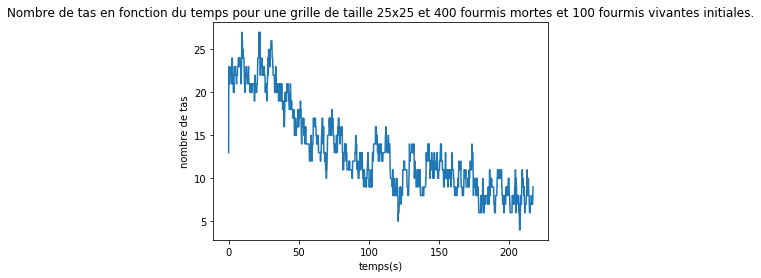

In [36]:
def plot_tas():
    
    x = np.array(liste_temps)
    y = np.array(liste_tas)
    plt.plot(x,y)
    plt.xlabel("temps(s)")
    plt.title("Nombre de tas en fonction du temps pour une grille de taille "+str(lignes)+"x"+str(colonnes)+" et "+str(init["DEAD"])+ " fourmis mortes et "+str(init["ALIVE"])+" fourmis vivantes initiales.")
    plt.ylabel("nombre de tas")
    plt.savefig("ClustersPlot.png")
    plt.show()

plot_tas()

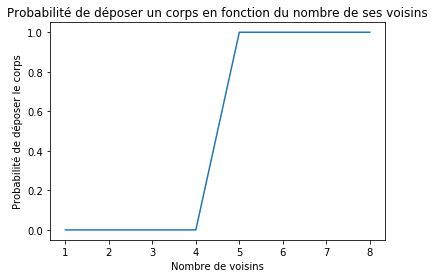

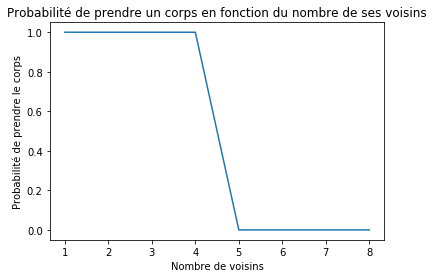

In [37]:
def plot_probabilite_prendre():
    x = [1,2,3,4,5,6,7,8]
    y=[]
    for i in range (1,9):
        if (i<=k1):
            y.append(1)
        else : 
            y.append(0)

    plt.xlabel("Nombre de voisins")
    plt.ylabel("Probabilité de prendre le corps")
    plt.plot(x, y)
    plt.title("Probabilité de prendre un corps en fonction du nombre de ses voisins")

    plt.show()
        
def plot_probabilite_depot():
    x = [1,2,3,4,5,6,7,8]
    y=[]
    for i in range (1,9):
        if (i>k2):
            y.append(1)
        else : 
            y.append(0)

    plt.xlabel("Nombre de voisins")
    plt.ylabel("Probabilité de déposer le corps")
    plt.plot(x, y)
    plt.title("Probabilité de déposer un corps en fonction du nombre de ses voisins")

    plt.show()
    
plot_probabilite_depot()
plot_probabilite_prendre()